In [2]:
%matplotlib notebook

import os
import glob
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import piff
from piff import Star
import fitsio
from piff.des.decaminfo import DECamInfo
dinfo = DECamInfo()

from esutil.htm import HTM
hmat = HTM()



In [3]:
# newer version of this material is in Make OptAtmo Star Summary

In [4]:
# locate all files - try Optics only
directory = "/nfs/slac/kipac/fs1/g/des/aresh/old_fit_checks_and_other_stuff/fit_checks_round36/dummy/y1_500_exposure_fit_check_band_i_shape_mode_round2"
psf_name = "psf_optatmo"
very_original_files = sorted(glob.glob('{0}/*/{1}.piff'.format(directory, psf_name)))

print(len(very_original_files))

500


In [5]:
# filter out the 'acceptable' files
acceptable_exposures = np.load("{0}/acceptable_exposures.npy".format(directory))
original_files = []
original_exposures = []
for very_original_file in very_original_files:
    very_original_exposure = very_original_file.split("/")[-2][2:]
    if very_original_exposure in acceptable_exposures:
        original_files.append(very_original_file)
        original_exposures.append(very_original_exposure)
        
print(len(original_files),original_files[0])

500 /nfs/slac/kipac/fs1/g/des/aresh/old_fit_checks_and_other_stuff/fit_checks_round36/dummy/y1_500_exposure_fit_check_band_i_shape_mode_round2/00228724/psf_optatmo.piff


In [6]:
# get h5 file names corresponding to these
h5_original_files = []
for afile in original_files:
    thedir = os.path.dirname(afile)
    h5_original_files.append(os.path.join(thedir,"shapes_train_psf_optatmo_opt_only.h5"))
print(len(h5_original_files),h5_original_files[0])

500 /nfs/slac/kipac/fs1/g/des/aresh/old_fit_checks_and_other_stuff/fit_checks_round36/dummy/y1_500_exposure_fit_check_band_i_shape_mode_round2/00228724/shapes_train_psf_optatmo_opt_only.h5


In [7]:
fits = fitsio.FITS(original_files[0])

In [8]:
# see what a .piff has...
print(fits)
print(fits['psf'])  #settings used in Piff
print(fits['psf_stars'])  #data for Train stars
print(fits['psf_wcs'])    #info about WCS solutions used
print(fits['psf_reference_wavefront'])  #info about the Reference wavefront
print(fits['psf_reference_wavefront_solution'])  #the actual Reference wavefront data used
print(fits['psf_solution'])    # optics fit parameters
print(fits['psf_test_stars']) #data for Test stars


  file: /nfs/slac/kipac/fs1/g/des/aresh/old_fit_checks_and_other_stuff/fit_checks_round36/dummy/y1_500_exposure_fit_check_band_i_shape_mode_round2/00228724/psf_optatmo.piff
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      psf
  2      BINARY_TBL      psf_stars
  3      BINARY_TBL      psf_wcs
  4      BINARY_TBL      psf_reference_wavefront
  5      BINARY_TBL      psf_reference_wavefront_solution
  6      BINARY_TBL      psf_optical_psf_kwargs
  7      BINARY_TBL      psf_kolmogorov_kwargs
  8      BINARY_TBL      psf_solution
  9      BINARY_TBL      psf_test_stars

  file: /nfs/slac/kipac/fs1/g/des/aresh/old_fit_checks_and_other_stuff/fit_checks_round36/dummy/y1_500_exposure_fit_check_band_i_shape_mode_round2/00228724/psf_optatmo.piff
  extension: 1
  type: BINARY_TBL
  extname: psf
  rows: 1
  column info:
    fov_radius          f8  
    shape_weights       f8  array[10]
    reference_wavefront_zernikes_list
                 

In [9]:
def fillOpticsParams(piff_files,exposures,outfile):
    # get the Optics fitted parameters

    # output file
    outfits = fitsio.FITS(outfile,'rw',clobber=True)
    
    # build parameter names
    allvarnames = ['L0','size','g1','g2']
    for iZp in range(4,37+1):
        for iZf in range(1,3+1):
            zvarname = 'zPupil%03d_zFocal%03d' % (iZp,iZf)
            allvarnames.append(zvarname)
    
    # use first file to find the floating variables
    fits = fitsio.FITS(piff_files[0])
    psf_solution = fits['psf_solution'].read()

    # selected floating parameters
    float_vars = []    
    for colname in allvarnames:
        isfixn = 'fix_' + colname
        if not psf_solution[isfixn]:
            float_vars.append(colname)
            float_vars.append("error_"+colname)

    # names,types
    dtype_tuple = []
    dtype_tuple.append(('expnum','i8'))
    for avar in float_vars:
        dtype_tuple.append((avar,'f8'))

    # loop over all files
    for i,afile in enumerate(piff_files):
        
        if i==20*int(i/20):
            print("File # ",i)
                    
        # output record array
        outdata = np.zeros(1, dtype=dtype_tuple)            
            
        # open file
        fits = fitsio.FITS(afile)
        psf_solution = fits['psf_solution'].read()

        # pull out desired values
        float_values = fits['psf_solution'].read(columns=float_vars)
        
        for avar in float_vars:
            outdata[avar] = float_values[avar]
        
        # add the exposure number...
        expnum = exposures[i]
        outdata['expnum'] = expnum

        # write out
        if i==0:
            # create a new table extension and write the data
            outfits.write(outdata,extname='fitparams')
        else:
            outfits[-1].append(outdata)
            
    # done
    outfits.close()

In [10]:
# write out all optics fit parameters
outpfile='/u/ec/roodman/kipacdisk/Piff/y1_500_i_shape_mode_round2_fitparams.fits'
fillOpticsParams(original_files,original_exposures,outpfile)

File #  0
File #  20
File #  40
File #  60
File #  80
File #  100
File #  120
File #  140
File #  160
File #  180
File #  200
File #  220
File #  240
File #  260
File #  280
File #  300
File #  320
File #  340
File #  360
File #  380
File #  400
File #  420
File #  440
File #  460
File #  480


In [11]:
# check the params...
print(fits['psf_test_stars'].get_colnames())
print(fits['psf_stars'].get_colnames())
ts = fits['psf_stars'].read()
print(ts['params'][0])

['x', 'y', 'u', 'v', 'chipnum', 'gain', 'sky', 'snr', 'ra', 'dec', 'shape', 'shape_error', 'dudx', 'dudy', 'dvdx', 'dvdy', 'xmin', 'xmax', 'ymin', 'ymax', 'flux', 'center', 'chisq', 'point_ra', 'point_dec']
['x', 'y', 'u', 'v', 'chipnum', 'gain', 'sky', 'snr', 'ra', 'dec', 'shape', 'shape_error', 'dudx', 'dudy', 'dvdx', 'dvdy', 'xmin', 'xmax', 'ymin', 'ymax', 'flux', 'center', 'chisq', 'params', 'params_var', 'point_ra', 'point_dec']
[-3.20701218e-02  2.74879936e-02  5.46909725e-02  8.31538742e+00
  1.09853743e+00 -1.43741226e-02 -4.53009826e-03 -1.43217186e-02
 -3.92383759e-01  1.43064143e-01  3.62509538e-01  1.66945664e-01
  2.18010844e-01  2.70844815e-01 -1.74960959e-01  2.10836225e-02
 -3.00725058e-02 -6.69342648e-02  3.32809277e-02  6.00508577e-03
  1.18249062e-02  6.95746184e-02  9.24120599e-03 -5.71065110e-03
  6.20899285e-03  6.31126562e-04  3.16526288e-02 -2.21815145e-02
 -6.52325608e-03 -2.35164179e-03  1.25188349e-04  4.55832037e-04
 -9.83105239e-03 -4.98100471e-03  5.260354

z04 is params[7] and zernikes follow to z37
optics_size is params[4], optics_g1 is [5], optics_g2 is [6]
L0 is params[3]

so probably atmo_size,atmo_g1,atmo_g2 are 0,1,2

also note that psf_test_stars doesn't have these params, just the train stars...

In [12]:
# check values from .h5 file
shapes_train = pd.read_hdf(h5_original_files[0])
print(shapes_train.columns)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1)
print(shapes_train)

Index(['chipnum', 'x', 'y', 'u', 'v', 'ra', 'dec', 'data_flux', 'data_u0',
       'data_v0', 'data_e0', 'data_e1', 'data_e2', 'data_zeta1', 'data_zeta2',
       'data_delta1', 'data_delta2', 'data_orth4', 'data_orth6', 'data_orth8',
       'snr', 'data_sigma_flux', 'data_sigma_u0', 'data_sigma_v0',
       'data_sigma_e0', 'data_sigma_e1', 'data_sigma_e2', 'data_sigma_zeta1',
       'data_sigma_zeta2', 'data_sigma_delta1', 'data_sigma_delta2',
       'data_sigma_orth4', 'data_sigma_orth6', 'data_sigma_orth8',
       'model_flux', 'model_u0', 'model_v0', 'model_e0', 'model_e1',
       'model_e2', 'model_zeta1', 'model_zeta2', 'model_delta1',
       'model_delta2', 'model_orth4', 'model_orth6', 'model_orth8', 'de0',
       'de1', 'de2', 'dzeta1', 'dzeta2', 'ddelta1', 'ddelta2', 'dorth4',
       'dorth6', 'dorth8', 'atmo_size', 'atmo_g1', 'atmo_g2', 'opt_L0',
       'optics_size', 'optics_g1', 'optics_g2', 'z04', 'z05', 'z06', 'z07',
       'z08', 'z09', 'z10', 'z11', 'z12', 'z13', 'z14', 

n piff =  12885
n h5 =  12986
(12885, 98)


<IPython.core.display.Javascript object>


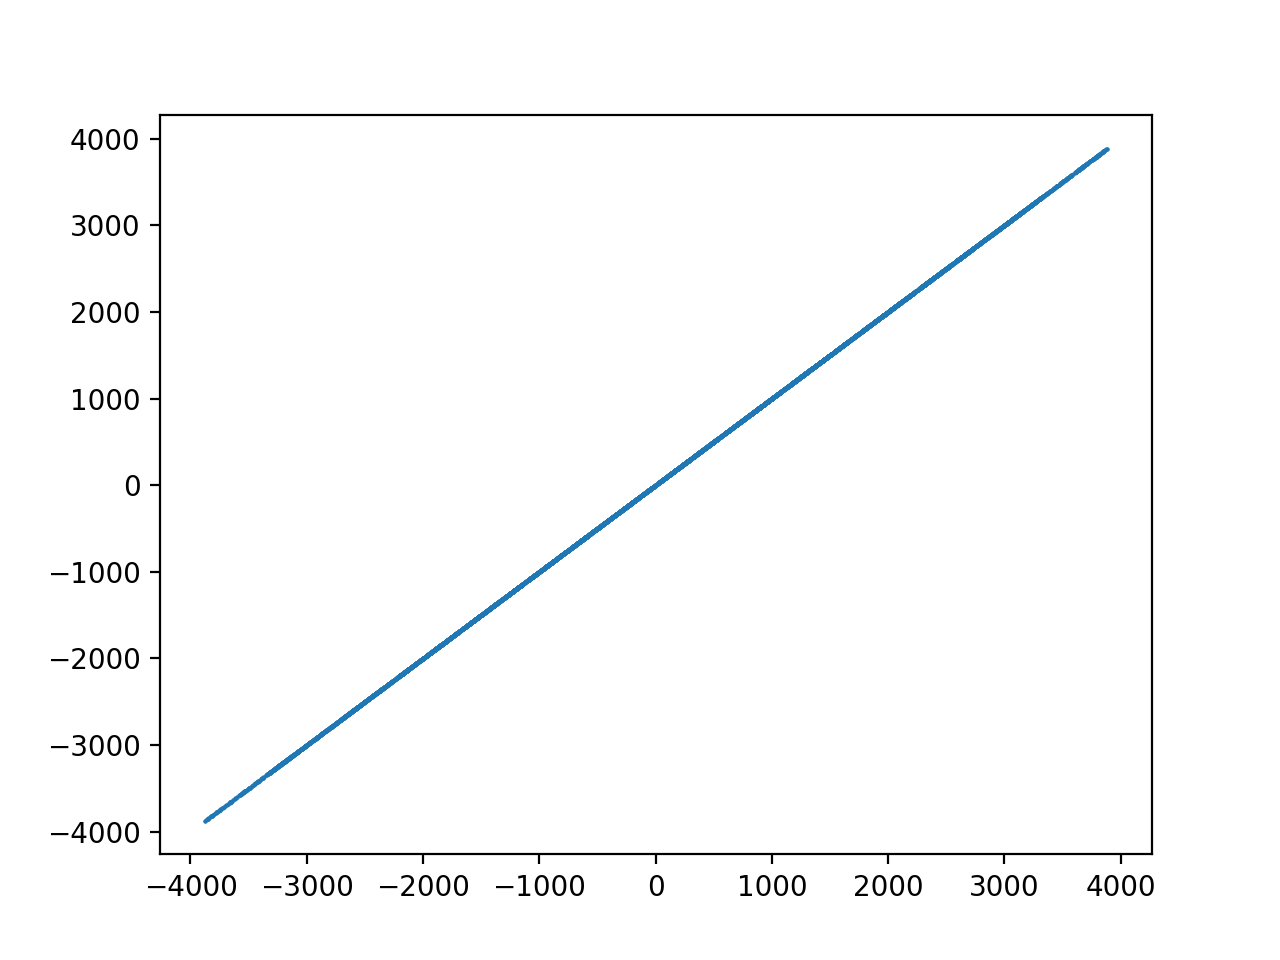

In [13]:
# work out matching between h5 and piff
u_h5 = shapes_train['u']
v_h5 = shapes_train['v']
ts = fits['psf_stars'].read()
u_piff = ts['u'][:]
v_piff = ts['v'][:]
print("n piff = ",len(u_piff))
print("n h5 = ",len(u_h5))

m1,m2,d12 = hmat.match(u_piff,v_piff,u_h5,v_h5,2./3600.,maxmatch=1)
# m2 has the index into _h5 that matches _piff

culled = shapes_train.iloc[m2,:]
print(culled.shape)
f,ax = plt.subplots(1,1)
h = ax.scatter(u_piff,culled['u'],marker='.',s=1.)


['x', 'y', 'u', 'v', 'chipnum', 'gain', 'sky', 'snr', 'ra', 'dec', 'shape', 'shape_error', 'dudx', 'dudy', 'dvdx', 'dvdy', 'xmin', 'xmax', 'ymin', 'ymax', 'flux', 'center', 'chisq', 'point_ra', 'point_dec']


<IPython.core.display.Javascript object>


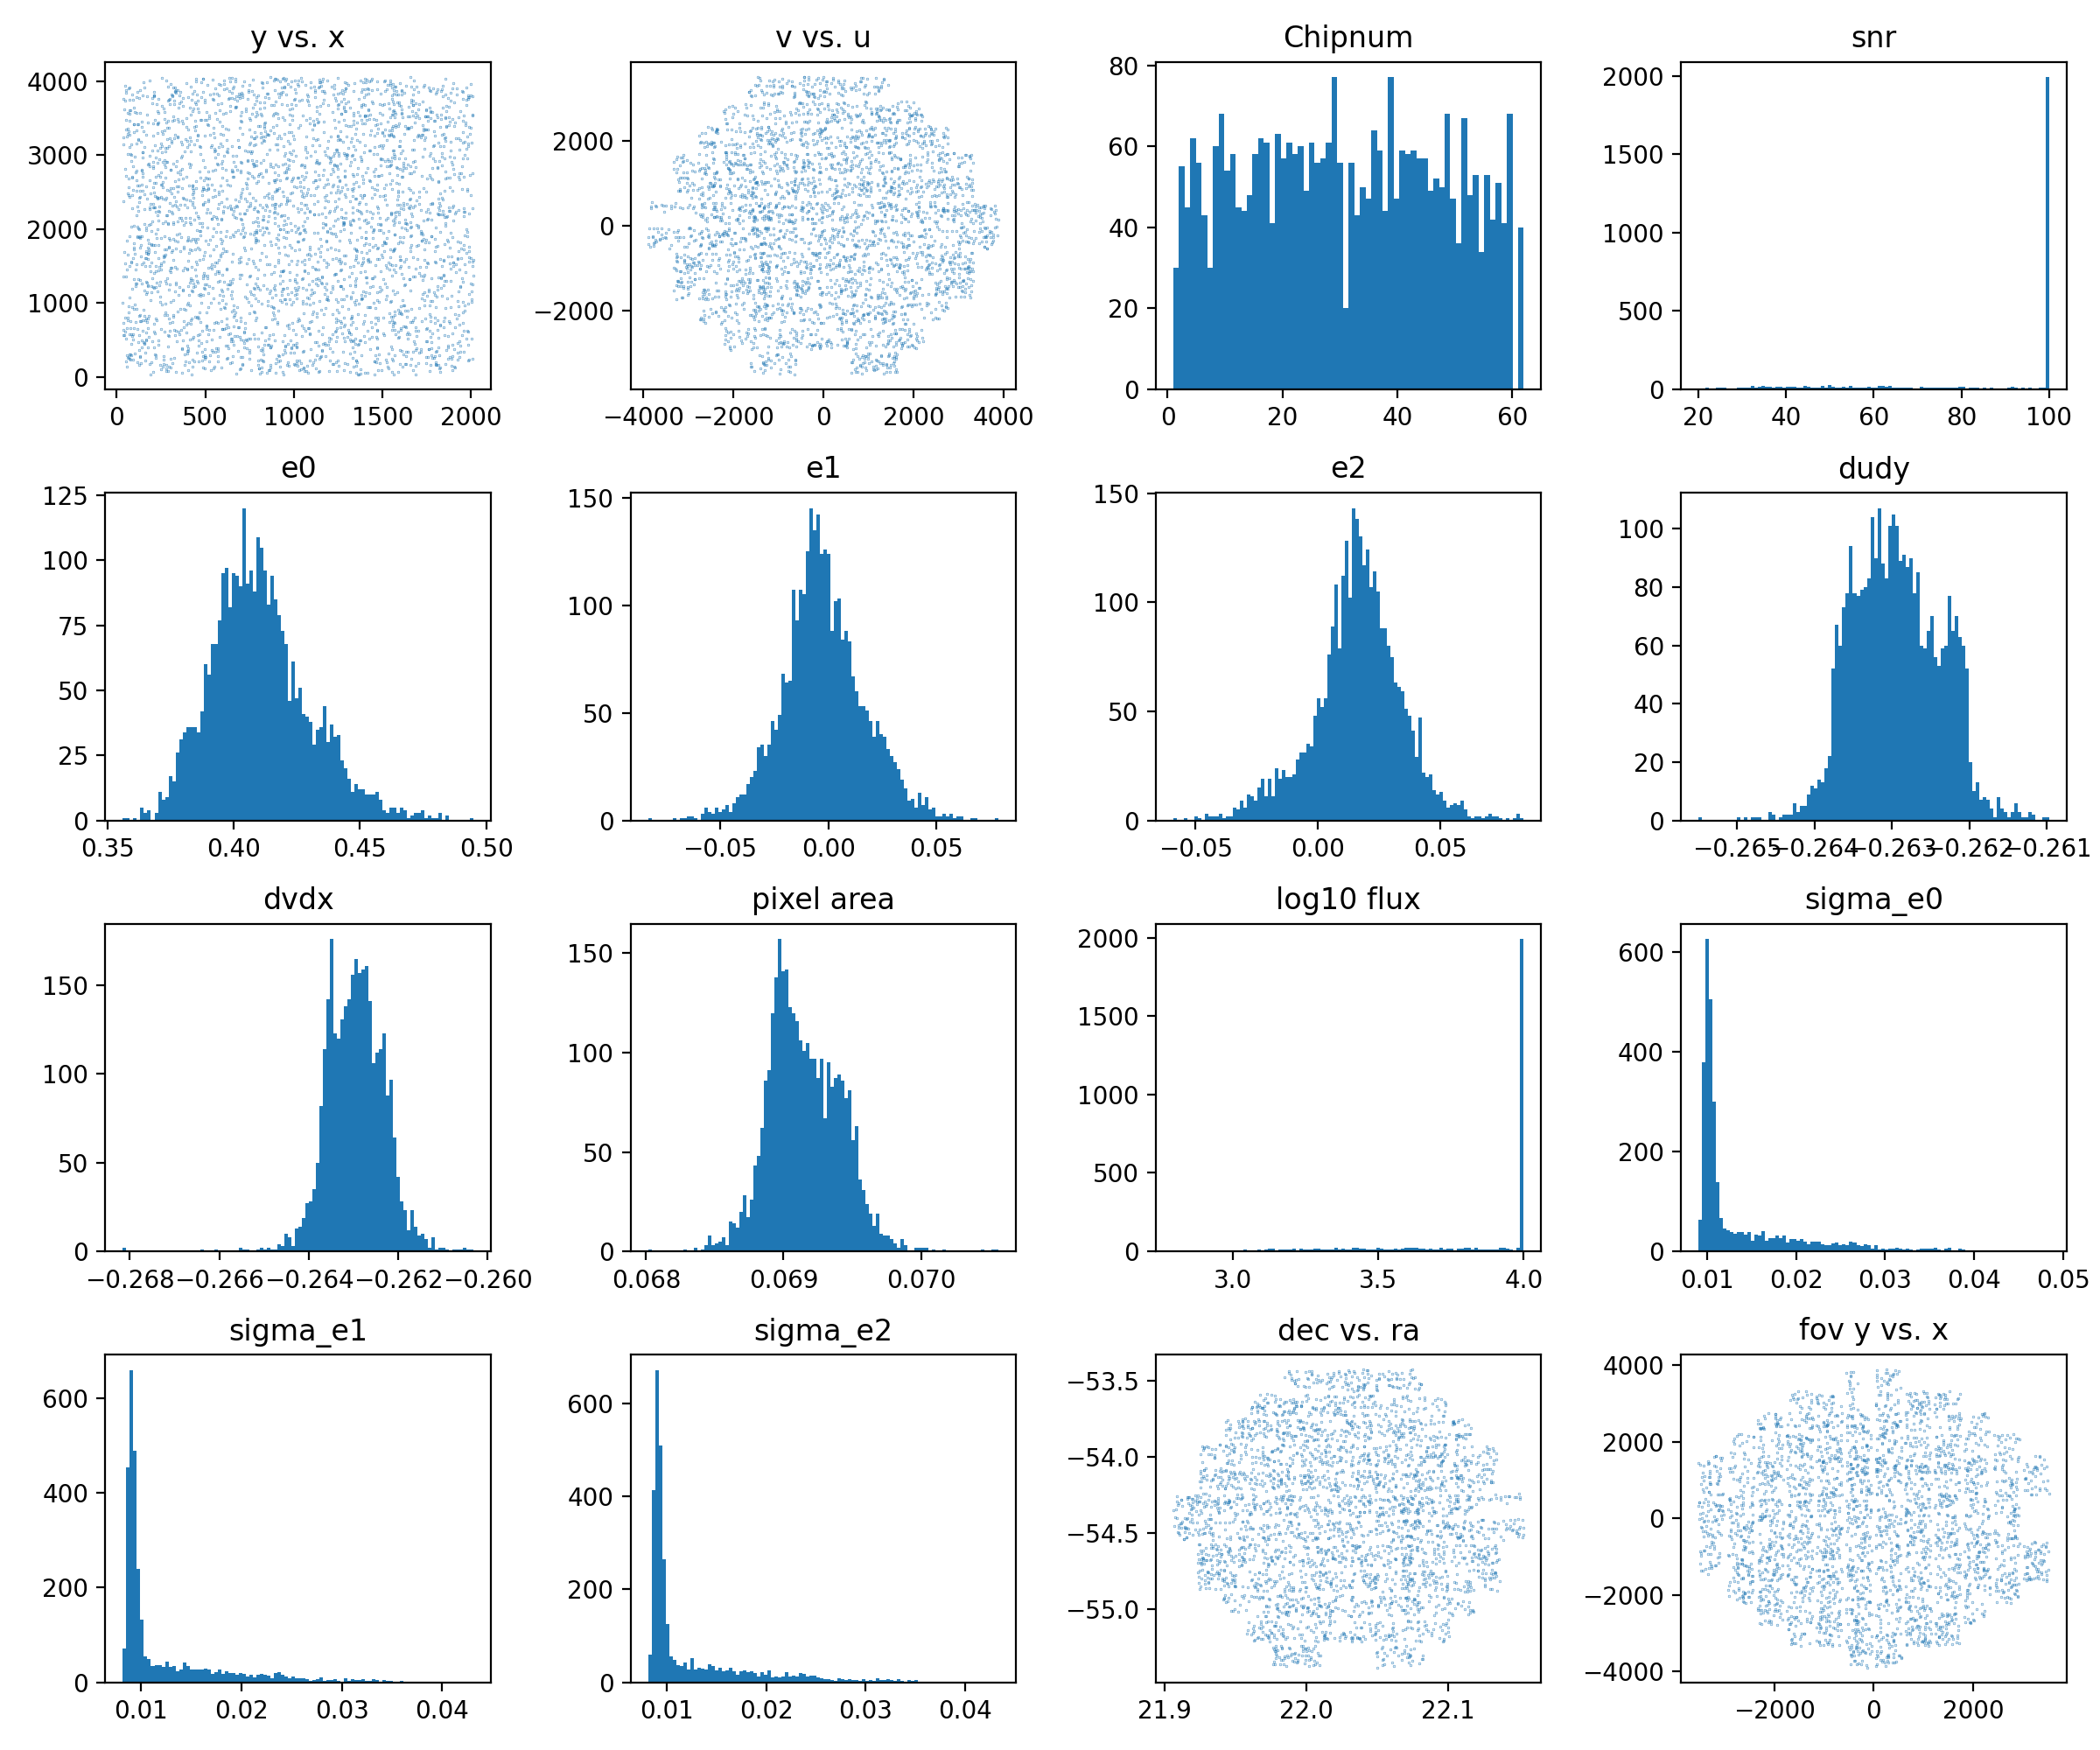

In [14]:
# plot variables for test stars
t = fits['psf_test_stars'].read()
print(fits['psf_test_stars'].get_colnames())
f,axa = plt.subplots(4,4,figsize=(12,10))
ax = axa.flatten()

ax[0].scatter(t['x'][:],t['y'][:],marker='.',s=0.1)
ax[0].set_title('y vs. x')
ax[1].scatter(t['u'][:],t['v'][:],marker='.',s=0.1)
ax[1].set_title('v vs. u')
ax[2].hist(t['chipnum'][:],bins=62)
ax[2].set_title('Chipnum')
ax[3].hist(t['snr'][:],bins=100)
ax[3].set_title('snr')
ax[4].hist(t['shape'][:,3],bins=100)
ax[4].set_title('e0')
ax[5].hist(t['shape'][:,4],bins=100)
ax[5].set_title('e1')
ax[6].hist(t['shape'][:,5],bins=100)
ax[6].set_title('e2')
ax[7].hist(t['dudy'][:],bins=100)
ax[7].set_title('dudy')
ax[8].hist(t['dvdx'][:],bins=100)
ax[8].set_title('dvdx')

# chisq are all nan
pixsiz = np.abs((t['dudx'][:] * t['dvdy'][:]) - (t['dudy'][:] * t['dvdx'][:]))
ax[9].hist(pixsiz,bins=100)
ax[9].set_title('pixel area')

# why isn't mag present?
ax[10].hist(np.log10(t['flux'][:]),bins=100)
ax[10].set_title('log10 flux')
ax[11].hist(t['shape_error'][:,3],bins=100)
ax[11].set_title('sigma_e0')
ax[12].hist(t['shape_error'][:,4],bins=100)
ax[12].set_title('sigma_e1')
ax[13].hist(t['shape_error'][:,5],bins=100)
ax[13].set_title('sigma_e2')
ax[14].scatter(t['ra'][:],t['dec'][:],marker='.',s=0.1)
ax[14].set_title('dec vs. ra')

# get fov_x,fov_y 
ix = t['x'][:] - 0.5
iy = t['y'][:] - 0.5
chipnums = t['chipnum'][:].astype(int)
fov_x,fov_y = dinfo.getPosition_chipnum(chipnums, ix, iy)
factor = (0.015/0.263) 
fov_x /= factor
fov_y /= factor

ax[15].scatter(fov_x,fov_y,marker='.',s=0.1)
ax[15].set_title('fov y vs. x')

plt.tight_layout()


In [15]:
d = fits['psf_stars'].read()
print(d['chisq'][:])    # nan
print(d['shape'][:,0])  # [0] is M00, and this seems also to be limited to 10^4

[341.68446448 350.62215414   9.17027587 ...  63.5925033   37.29435936
  31.32489639]
[1793.14102662 1403.68995519 9914.9281326  ... 9834.91609337 9838.73873509
 9862.4630714 ]


In [16]:
print(d.dtype)
print(d.dtype.names)
print(d.shape[0])

[('x', '>f8'), ('y', '>f8'), ('u', '>f8'), ('v', '>f8'), ('chipnum', '>f8'), ('gain', '>f8'), ('sky', '>f8'), ('snr', '>f8'), ('ra', '>f8'), ('dec', '>f8'), ('shape', '>f8', (13,)), ('shape_error', '>f8', (13,)), ('dudx', '>f8'), ('dudy', '>f8'), ('dvdx', '>f8'), ('dvdy', '>f8'), ('xmin', '>i8'), ('xmax', '>i8'), ('ymin', '>i8'), ('ymax', '>i8'), ('flux', '>f8'), ('center', '>f8', (2,)), ('chisq', '>f8'), ('params', '>f8', (41,)), ('params_var', '>f8', (41,)), ('point_ra', '>f8'), ('point_dec', '>f8')]
('x', 'y', 'u', 'v', 'chipnum', 'gain', 'sky', 'snr', 'ra', 'dec', 'shape', 'shape_error', 'dudx', 'dudy', 'dvdx', 'dvdy', 'xmin', 'xmax', 'ymin', 'ymax', 'flux', 'center', 'chisq', 'params', 'params_var', 'point_ra', 'point_dec')
12885


In [17]:
# now get data from all the Train stars - from both .piff and .h5 files
# 
# we want x,y,u,v,chipnum,ra,dec,shape[3:5],shape_error[3:5],fov_x,fov_y from .piff
# and model_e0,model_e1,model_2, optics_size, optics_g1, optics_g2, atmo_size, atmo_g1, atmo_g2 from .h5

def concat_stars(piff_files,h5_files,outfile,
                 piffcols = ['x','y','u','v','chipnum','ra','dec',
                             'e0','e1','e2','se0','se1','se2', # variables in shape
                             'fov_x','fov_y','pix_area', # variables calculated from others
                             'atmo_size','atmo_g1','atmo_g2','optics_L0','optics_size','optics_g1','optics_g2'],  # variables in params 0 to 6
                 h5cols=['model_e0', 'model_e1','model_e2']):
    """ from a list of .piff files, collect star information and concatenate into a single file
    """
    
    # output variables
    dtype_tuple = []
    for avar in piffcols:
        dtype_tuple.append((avar,'f8'))
    for avar in h5cols:
        dtype_tuple.append((avar,'f8'))
        
        
    # output file
    outfits = fitsio.FITS(outfile,'rw',clobber=True)
            
    for i,f in enumerate(piff_files):
        if i==20*np.int(i/20): print('Loading file {0} of {1}'.format(i, len(piff_files)))
        fits = fitsio.FITS(f)
        h5f = pd.read_hdf(h5_files[i])  # assume files are ordered the same!!
            
        # use only Test stars from .piff file
        extnames = 'psf_stars'
        d = fits[extnames].read()
        piff_names = d.dtype.names
        
        # match the stars in the h5 file (it has more stars)
        u_h5 = h5f['u']
        v_h5 = h5f['v']
        u_piff = d['u'][:]
        v_piff = d['v'][:]

        # use idx_to_h5
        idx_to_piff,idx_to_h5,dista = hmat.match(u_piff,v_piff,u_h5,v_h5,2./3600.,maxmatch=1)
        h5fc = h5f.iloc[idx_to_h5]
        
                
        # setup output recarray
        nrows = d.shape[0]
        outdata = np.zeros(nrows, dtype=dtype_tuple)
    
        for var in piffcols:
            if var in piff_names:
                outdata[var] = d[var]
            else:
                # build the variable from shape or params
                if var == 'e0':
                    outdata[var] = d['shape'][:,3]
                elif var == 'e1':
                    outdata[var] = d['shape'][:,4]
                elif var == 'e2':
                    outdata[var] = d['shape'][:,5]
                elif var == 'se0':
                    outdata[var] = d['shape_error'][:,3]
                elif var == 'se1':
                    outdata[var] = d['shape_error'][:,4]
                elif var == 'se2':
                    outdata[var] = d['shape_error'][:,5]
                elif var == 'fov_x':                    
                    ix = d['x'][:] - 0.5
                    iy = d['y'][:] - 0.5
                    chipnums = d['chipnum'][:].astype(int)
                    fov_x,fov_y = dinfo.getPosition_chipnum(chipnums, ix, iy)
                    factor = (0.015/0.263) 
                    fov_x /= factor
                    fov_y /= factor                    
                    outdata[var] = fov_x
                elif var == 'fov_y':                    
                    ix = d['x'][:] - 0.5
                    iy = d['y'][:] - 0.5
                    chipnums = d['chipnum'][:].astype(int)
                    fov_x,fov_y = dinfo.getPosition_chipnum(chipnums, ix, iy)
                    factor = (0.015/0.263) 
                    fov_x /= factor
                    fov_y /= factor                    
                    outdata[var] = fov_y
                elif var == 'pix_area':
                    pixsiz = np.abs((d['dudx'][:] * d['dvdy'][:]) - (d['dudy'][:] * d['dvdx'][:]))
                    outdata[var] = pixsiz
                elif var == 'atmo_size':
                    outdata[var] = d['params'][:,0]
                elif var == 'atmo_g1':
                    outdata[var] = d['params'][:,1]                        
                elif var == 'atmo_g2':
                    outdata[var] = d['params'][:,2]                    
                elif var == 'optics_L0':
                    outdata[var] = d['params'][:,3]                    
                elif var == 'optics_size':
                    outdata[var] = d['params'][:,4]
                elif var == 'optics_g1':
                    outdata[var] = d['params'][:,5]
                elif var == 'optics_g2':
                    outdata[var] = d['params'][:,6]                        
             
        # h5 has more stars than the .piff, need to match them!
        for var in h5cols:
            outdata[var] = h5fc[var]

                    
                    
        # write out
        if i==0:
            # create a new table extension and write the data
            outfits.write(outdata,extname='psf_stars')
        else:
            outfits[-1].append(outdata)
            
    # done
    outfits.close()
                    
                    

In [18]:
outfile='/u/ec/roodman/kipacdisk/Piff/y1_500_i_shape_mode_round2.fits'
concat_stars(original_files,h5_original_files,outfile)


Loading file 0 of 500
Loading file 20 of 500
Loading file 40 of 500
Loading file 60 of 500
Loading file 80 of 500
Loading file 100 of 500
Loading file 120 of 500
Loading file 140 of 500
Loading file 160 of 500
Loading file 180 of 500
Loading file 200 of 500
Loading file 220 of 500
Loading file 240 of 500
Loading file 260 of 500
Loading file 280 of 500
Loading file 300 of 500
Loading file 320 of 500
Loading file 340 of 500
Loading file 360 of 500
Loading file 380 of 500
Loading file 400 of 500
Loading file 420 of 500
Loading file 440 of 500
Loading file 460 of 500
Loading file 480 of 500


In [19]:
outfile='/u/ec/roodman/kipacdisk/Piff/y1_500_i_shape_mode_round2.fits'
af = fitsio.FITS(outfile)
print(af['psf_stars'])


  file: /u/ec/roodman/kipacdisk/Piff/y1_500_i_shape_mode_round2.fits
  extension: 1
  type: BINARY_TBL
  extname: psf_stars
  rows: 6526397
  column info:
    x                   f8  
    y                   f8  
    u                   f8  
    v                   f8  
    chipnum             f8  
    ra                  f8  
    dec                 f8  
    e0                  f8  
    e1                  f8  
    e2                  f8  
    se0                 f8  
    se1                 f8  
    se2                 f8  
    fov_x               f8  
    fov_y               f8  
    pix_area            f8  
    atmo_size           f8  
    atmo_g1             f8  
    atmo_g2             f8  
    optics_L0           f8  
    optics_size         f8  
    optics_g1           f8  
    optics_g2           f8  
    model_e0            f8  
    model_e1            f8  
    model_e2            f8  


<IPython.core.display.Javascript object>


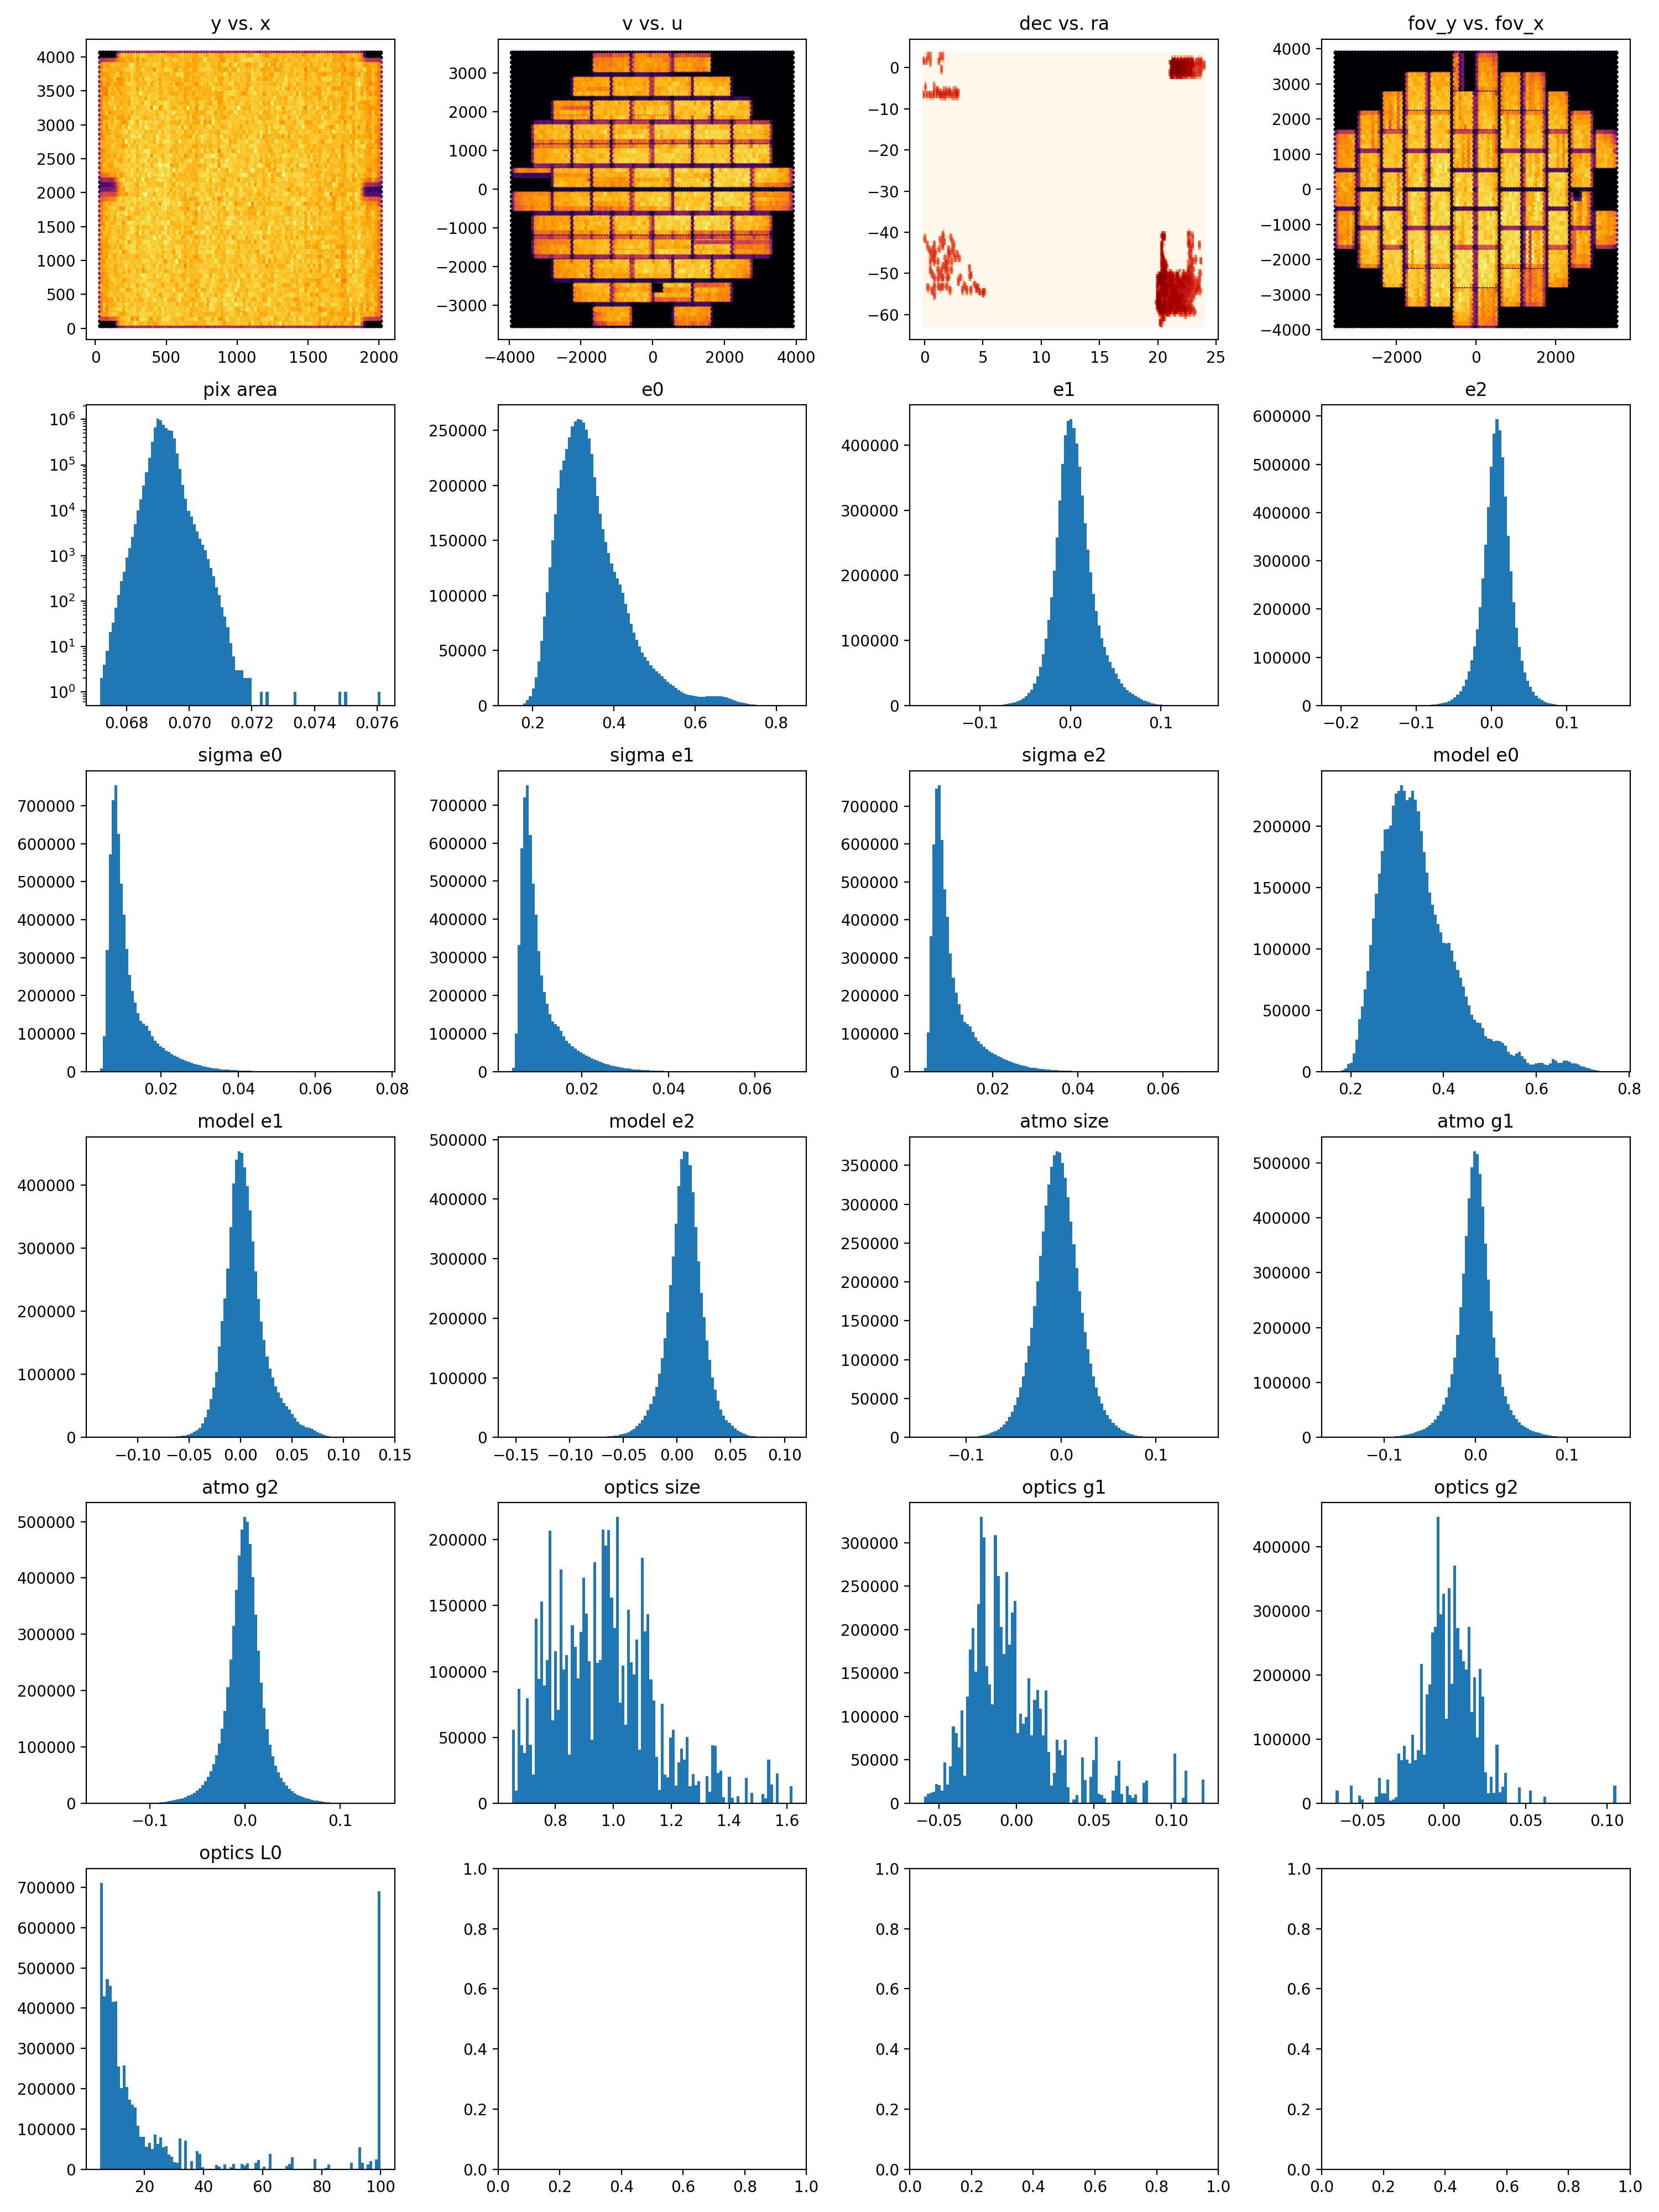

In [20]:
# plot variables for test stars
t = af['psf_stars'].read()

f,axa = plt.subplots(6,4,figsize=(15,20))
ax = axa.flatten()

ax[0].hexbin(t['x'][:],t['y'][:],gridsize=100, cmap='inferno')
ax[0].set_title('y vs. x')
ax[1].hexbin(t['u'][:],t['v'][:],gridsize=100, cmap='inferno') 
ax[1].set_title('v vs. u')
ax[2].hexbin(t['ra'][:],t['dec'][:],gridsize=200, cmap='OrRd', norm=colors.LogNorm(vmin=1., vmax=1.e4))
ax[2].set_title('dec vs. ra')
ax[3].hexbin(t['fov_x'][:],t['fov_y'][:],gridsize=100, cmap='inferno') 
ax[3].set_title('fov_y vs. fov_x')
ax[4].hist(t['pix_area'][:],bins=100)
ax[4].set_yscale('log')
ax[4].set_title('pix area')
ax[5].hist(t['e0'][:],bins=100)
ax[5].set_title('e0')
ax[6].hist(t['e1'][:],bins=100)
ax[6].set_title('e1')
ax[7].hist(t['e2'][:],bins=100)
ax[7].set_title('e2')
ax[8].hist(t['se0'][:],bins=100)
ax[8].set_title('sigma e0')
ax[9].hist(t['se1'][:],bins=100)
ax[9].set_title('sigma e1')
ax[10].hist(t['se2'][:],bins=100)
ax[10].set_title('sigma e2')
ax[11].hist(t['model_e0'][:],bins=100)
ax[11].set_title('model e0')
ax[12].hist(t['model_e1'][:],bins=100)
ax[12].set_title('model e1')
ax[13].hist(t['model_e2'][:],bins=100)
ax[13].set_title('model e2')
ax[14].hist(t['atmo_size'][:],bins=100)
ax[14].set_title('atmo size')
ax[15].hist(t['atmo_g1'][:],bins=100)
ax[15].set_title('atmo g1')
ax[16].hist(t['atmo_g2'][:],bins=100)
ax[16].set_title('atmo g2')
ax[17].hist(t['optics_size'][:],bins=100)
ax[17].set_title('optics size')
ax[18].hist(t['optics_g1'][:],bins=100)
ax[18].set_title('optics g1')
ax[19].hist(t['optics_g2'][:],bins=100)
ax[19].set_title('optics g2')
ax[20].hist(t['optics_L0'][:],bins=100)
ax[20].set_title('optics L0')

plt.tight_layout()